In [1]:
import torch ## main pytorch library, gives access to tensors, random generators, utils like data loaders, etc.
import torch.nn as nn ## neural network stuff like layers
import torch.nn.functional as F ## functions used in nn like activation functions, loss functions, drop functions, etc.
import torch.optim as optim ## optimizers

import torchvision ## library related to image analysis including ready datasets and trained models
import torchvision.transforms as transforms ## modules help with image data preprocessing such as transfromations

import matplotlib.pyplot as plt
import seaborn as sns # type: ignore
sns.set()

import numpy as np

torch.manual_seed(42)

### Load Dataset
* Remember, despite providing the transforms as a parameter when preparing the dataset, it won't apply the transforms functions until you use dataloader to load the data.
    * here a data pipeline is created through which the data will flow and multiple transforms will be applied.
However, until torch.utils.data.DataLoader is called, transformations on the data won't be applied

In [2]:
train_batch_size = 240
test_batch_size = 1000
# specify the transforms
train_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(0.13, 0.31)
                                    ])

# prepare the dataset
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)

validation_samples_n = int(0.1*len(mnist_dataset))
from torch.utils.data import random_split
# Divide the dataset into train and validation sets
trainset, validationset = random_split(mnist_dataset, [len(mnist_dataset) - validation_samples_n, validation_samples_n])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=4)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=len(validationset), shuffle=True, num_workers=4)

# Create test set and define test dataloader
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=train_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=True, num_workers=4)

# explore the loaded dataset
images, labels = next(iter(testloader))
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(images.min(), images.max()))
print('Mean Pixel Value: {} \nPixel Values Std: {}'.format(images.float().mean(), images.float().std()))

Min Pixel Value: -0.4193548262119293 
Max Pixel Value: 2.8064515590667725
Mean Pixel Value: 0.011122521013021469 
Pixel Values Std: 1.004960298538208


In [3]:
images[0].shape

torch.Size([1, 28, 28])

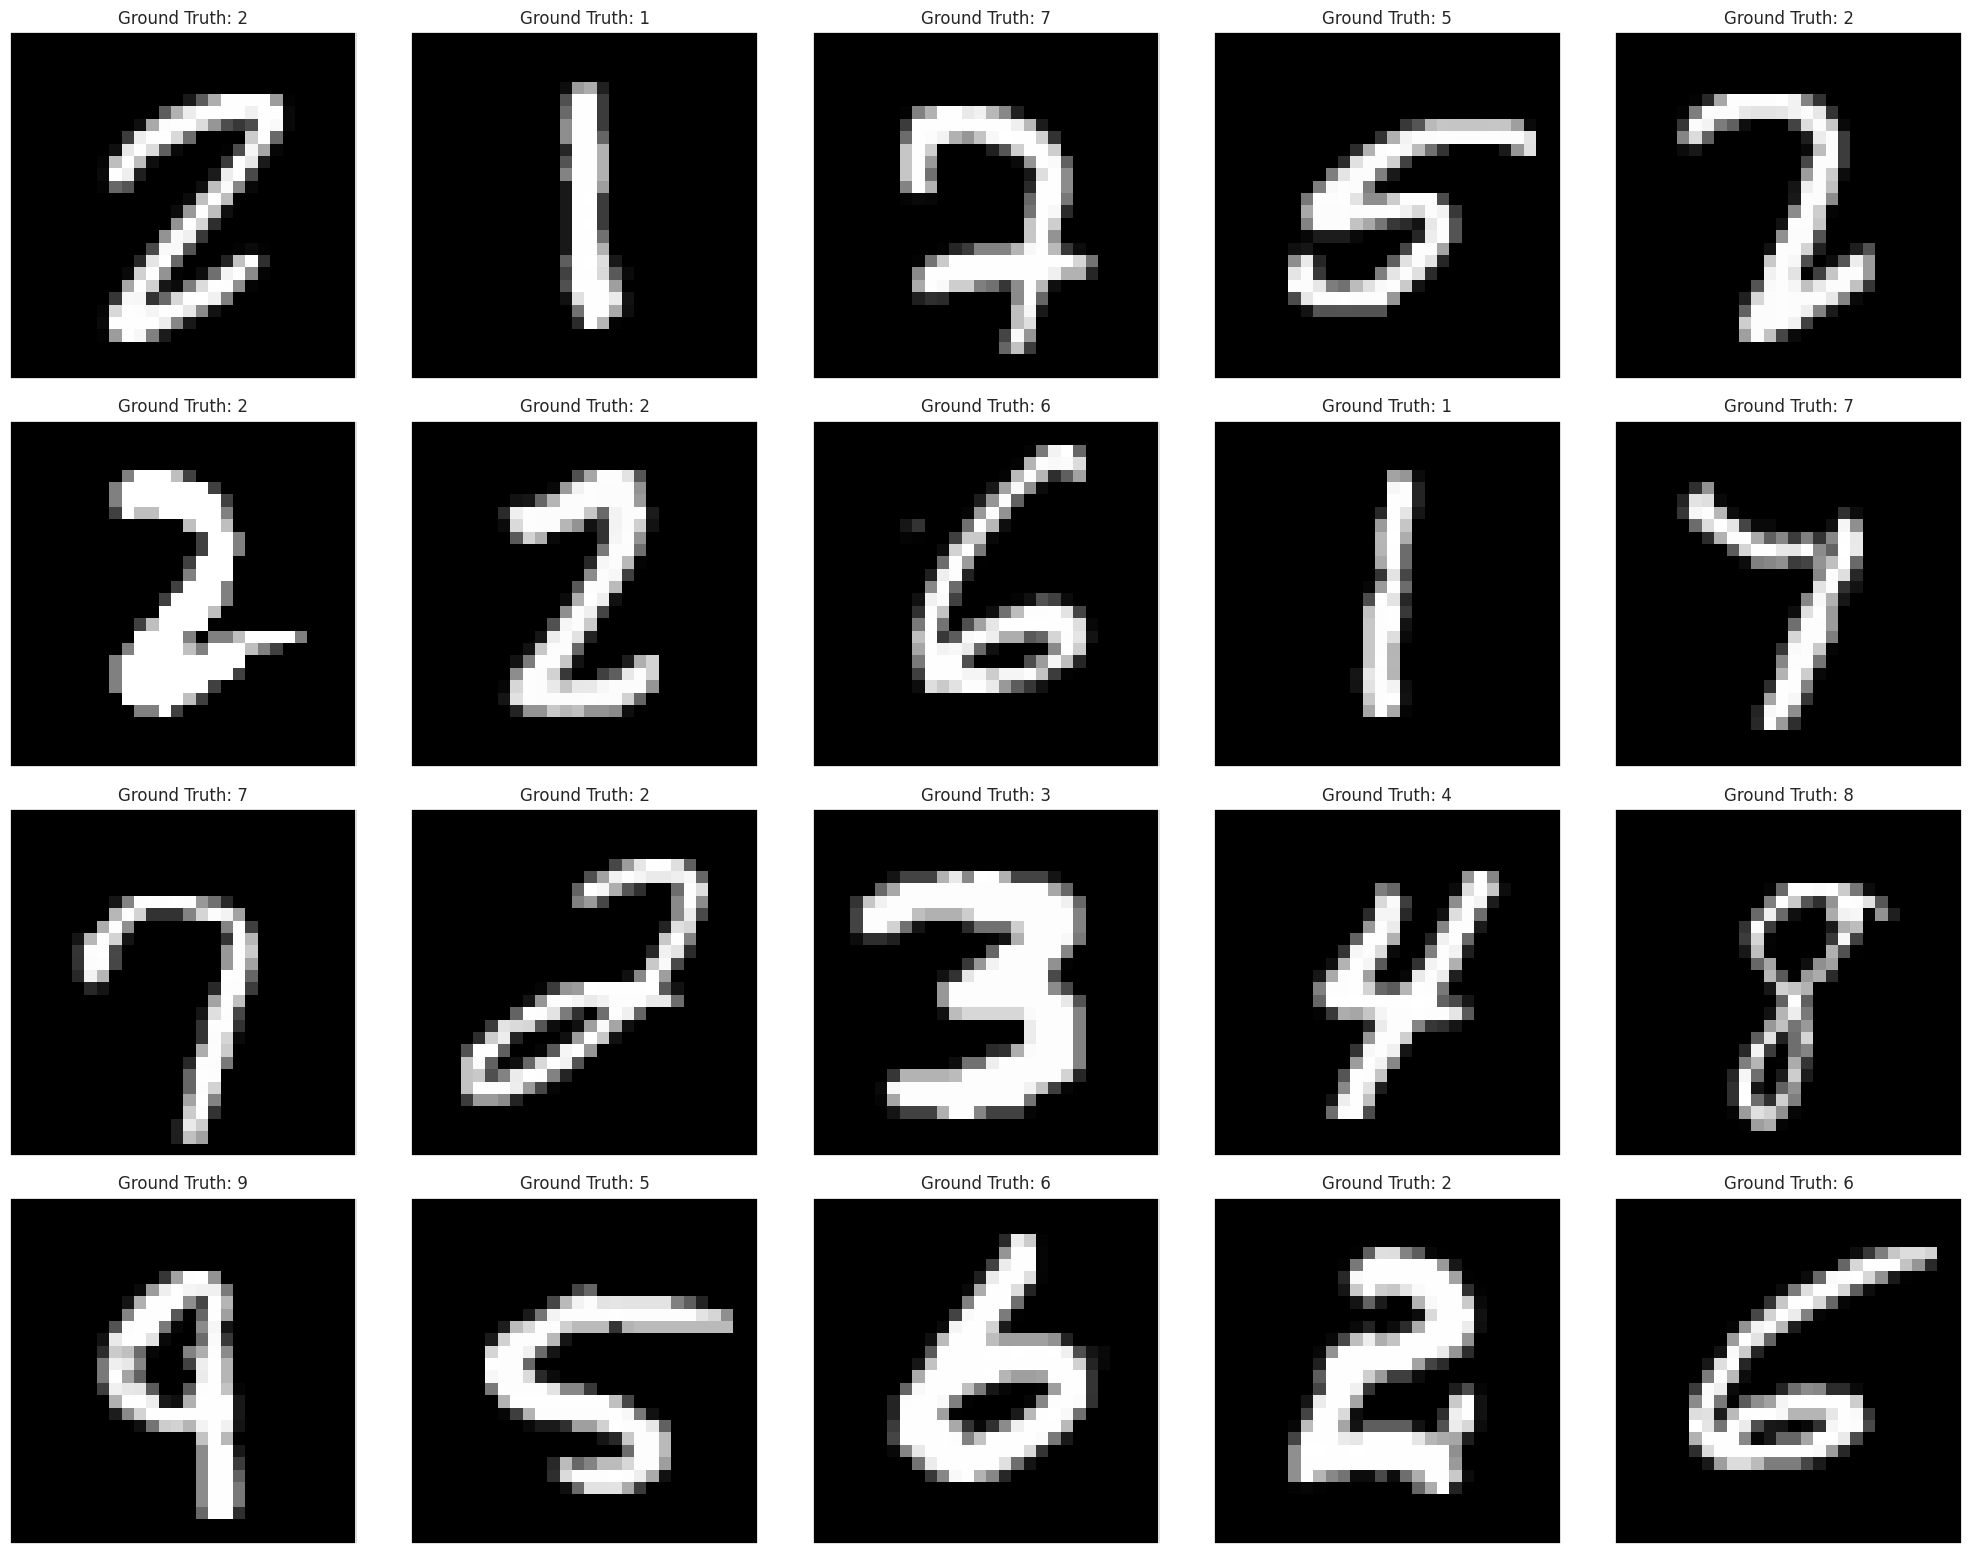

In [4]:
fig = plt.figure(figsize=(20,16))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])
fig;

### Build the Neural Network Model
* nn.Module or nn.Sequential can be used similarly
    * as explained [here](https://discuss.pytorch.org/t/differences-between-writing-models-with-nn-sequential-vs-creating-a-class/17470):
        * You can use whatever fits your use case.
        * While some people like to use the nn.Sequential approach a lot, I usually just use it for small sub-modules and like to define my model in a functional way, i.e. derive from nn.Module and write the forward method myself.
        * This approach gives you more flexibility in my opinion, since you are able to easily create skip connections etc.
        * On the other hand if you just want to stack layers together, nn.Sequential is totally fine.
    * example of nn.Sequential
        * `net = nn.Sequential(
      nn.Linear(3, 4),
      nn.Sigmoid(),
      nn.Linear(4, 1),
      nn.Sigmoid()
      ).to(device)`
___
* The nn.Module is a base class for all neural network modules in PyTorch.
* when calling init of super, in previous versions of python, one had to specify two arguments subclass name and self
    * `super(SubclassName, self).__init__()`

In [5]:
def set_device():
    device = torch.device('cpu')
    if torch.cuda.is_available():
        device = torch.device('cuda')
    return device

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # define the layers
        self.activation = F.relu
        self.out_activation = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.2)
        self.to(device=set_device())
        self.layer1 = nn.Linear(28 * 28 * 1, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 32)
        self.layer6 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 10)
    
    # automagically called with the instantiated object is called with paranthesis
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer2(x))
        x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer3(x))
        x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer4(x))
        x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer5(x))
        x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer6(x))
        x = self.dropout(x)
        # print(x.shape)
        x = self.output(x)
        # x = self.output2(x)
        return x

# Instantiate the model
# model = Net()
# print(model)
# model.to(device=set_device())

# torch.Size([250, 512])
# torch.Size([250, 256])
# torch.Size([250, 128])
# torch.Size([250, 64])
# torch.Size([250, 32])
# torch.Size([250, 16])

#### Model 2

* [I use softmax as output when using cross entropy loss in pytorch?](https://stackoverflow.com/questions/55675345/should-i-use-softmax-as-output-when-using-cross-entropy-loss-in-pytorchShould) says you should not use softmax before CrossEntropyLoss.
* also [this one](https://stackoverflow.com/questions/64519911/do-i-have-to-add-softmax-in-def-forward-when-i-use-torch-nn-crossentropyloss) says "with torch.nn.CrossEntropyLoss there is no need to include softmax layer. If one does include softmax it will still lead to proper classification result, since softmax does not change which element has max score. However, if applied twice, it may distort relative levels of the outputs, making gradients less strong and potentially slowing training a bit."
    * this really actually happened in my case where the models' last output was with activation softmax
    the crossEntropy was also applying softmax on network softmax thus the error calculation was inaccurate and the gradient steps where very very small

In [6]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        # define the layers
        self.activation = F.relu
        self.out_activation = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.2)
        self.to(device=set_device())
        self.layer1 = nn.Linear(28 * 28 * 1, 128)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 32)
        self.layer6 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 10)
    
    # automagically called with the instantiated object is called with paranthesis
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        x = self.dropout(x)
        # print(x.shape)
        # x = self.activation(self.layer2(x))
        # x = self.dropout(x)
        # # print(x.shape)
        # x = self.activation(self.layer3(x))
        # x = self.dropout(x)
        # # print(x.shape)
        x = self.activation(self.layer4(x))
        x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer5(x))
        x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer6(x))
        x = self.dropout(x)
        # print(x.shape)
        x = self.output(x)
        # x = self.output2(x)
        return x


### Model 3

In [7]:
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        # define the layers
        self.activation_relu = F.relu
        self.activation_tanh = F.tanh
        self.out_activation = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.2)
        self.to(device=set_device())
        self.layer1 = nn.Linear(28 * 28 * 1, 100)
        self.layer2 = nn.Linear(100, 100)
        self.layer3 = nn.Linear(100, 50)
        self.layer4 = nn.Linear(50, 25)
        self.layer5 = nn.Linear(25, 13)
        self.output = nn.Linear(13, 10)
    
    # automagically called with the instantiated object is called with paranthesis
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation_tanh(self.layer1(x))
        x = self.activation_relu(self.layer2(x))
        x = self.activation_relu(self.layer3(x))
        x = self.activation_relu(self.layer4(x))
        x = self.activation_relu(self.layer5(x))
        x = self.dropout(x)
        
        x = self.output(x)
        return x

In [8]:
"""
a model with no dropouts
maybe the reason for high training accuracy than validation is because the dropout causes 
the model to be weak during training
"""
class Net4(nn.Module):
    def __init__(self):
        super().__init__()
        # define the layers
        self.activation = F.relu
        self.out_activation = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.2)
        self.to(device=set_device())
        self.layer1 = nn.Linear(28 * 28 * 1, 128)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 32)
        self.layer6 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 10)
    
    # automagically called with the instantiated object is called with paranthesis
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        # x = self.dropout(x)
        # x = self.activation(self.layer2(x))
        # x = self.dropout(x)
        # x = self.activation(self.layer3(x))
        # x = self.dropout(x)
        x = self.activation(self.layer4(x))
        # x = self.dropout(x)
        x = self.activation(self.layer5(x))
        # x = self.dropout(x)
        x = self.activation(self.layer6(x))
        # x = self.dropout(x)
        x = self.output(x)
        # x = self.output2(x)
        return x


#### Initialize Model

In [9]:
model = Net2()

### define the optimizers and loss function

In [10]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

#### Early Stopping class

In [11]:
class ValidationLossEarlyStopping:
    def __init__(self, patience=1, min_delta=0.0):
        self.patience = patience  # number of times to allow for no improvement before stopping the execution
        self.min_delta = min_delta  # the minimum tolerance to be counted as improved/worsened
        self.counter = 0  # count the number of times the validation accuracy not improving
        self.min_validation_loss = np.inf
# validation loss: 0.1575,                   
# self.min_validation_loss: 0.2076
# 0.05
    # return True when encountering _patience_ times decrease in validation loss 
    def early_stop_check(self, validation_loss):
        # print(f'validation_loss: {validation_loss}, \
        #           self.min_validation_loss: {self.min_validation_loss}, \
        #           self.min_delta: {self.min_delta}, self.counter:{self.counter}')
        if ((validation_loss+self.min_delta) < self.min_validation_loss):
            # print("RESET")
            self.min_validation_loss = validation_loss
            self.counter = 0  # reset the counter if validation decreased
        elif validation_loss+self.min_delta > self.min_validation_loss:
            self.counter += 1
            # print("COUNTER+1")
            if self.counter >= self.patience:
                return True
        return False
    
    # class EarlyStopper:
    #     def __init__(self, patience=1, min_delta=0):
    #         self.patience = patience
    #         self.min_delta = min_delta
    #         self.counter = 0
    #         self.min_validation_loss = np.inf
    # def early_stop(self, validation_loss):
    #     if validation_loss < self.min_validation_loss:
    #         self.min_validation_loss = validation_loss
    #         self.counter = 0
    #     elif validation_loss > (self.min_validation_loss + self.min_delta):
    #         self.counter += 1
    #         if self.counter >= self.patience:
    #             return True
    #     return False

In [12]:
def train(model, trainloader, verbose=1):
    """
   Train the model on a trainloader.

   :param Model model: The model to be trained
   :param DataLoader trainloader: The data to be used for training
   :param int verbose: Show numbers per batch
   :returns the a list of batch losses, the epoch loss, and the accuracy
   :rtype: Union[batch_losses, epoch_loss, epoch_accuracy]
   """
    model.train()
    
    batch_losses = []
    batch_accuracies = []
    batch_loss_sum = 0
    correct_pred_total = 0
    total_samples = 0
    for batch_idx, (input, target) in enumerate(trainloader):
        # making a pridiction in forward pass
        y_hat = model(input)
        # calculating the loss between original and predicted data points
        loss = criterion(y_hat, target)
        # sum the losses
        current_batch_loss= loss.item()
        batch_loss_sum += current_batch_loss
        # store loss into list
        batch_losses.append(current_batch_loss)
        # calculate the train accuracy
        # torch.max returns value and index of largest number
        # since softmax produces probability for 0 classes,
        # the index will exactly match the corresponding number
        # _, predicted = torch.max(y_hat.data, 1) # if model output is softmax
        # b = torch.softmax(y_hat, dim=)
        _, predicted = torch.max(y_hat.data, 1)
        total_samples += target.size(0)
        # correct_pred_total += (predicted == target).sum().item()  
        correct_preds = (predicted == target).sum().item()
        correct_pred_total += correct_preds
        current_accuracy = round(correct_preds/len(target), 2)
        batch_accuracies.append(current_accuracy)

        # zeroing gradients after each iteration
        optimizer.zero_grad()
        # backward pass for computing the gradients of the loss w.r.t to learnable parameters
        loss.backward()
        # updateing the parameters after each iteration
        optimizer.step()
        if(verbose):
            print(f'Train Batch: {batch_idx}: Train Loss: {current_batch_loss}, Train Accuracy: {current_accuracy*100}%')
    epoch_loss = round(batch_loss_sum/len(trainloader), 4)
    epoch_accuracy = round((correct_pred_total/total_samples)*100,2)
    return batch_losses, epoch_loss, epoch_accuracy

Define Validation

In [13]:
def validation(model, validationloader, verbose=1):
    """
    Train the model on a trainloader.

    :param Model model: The model to be validated
    :param DataLoader validationloader: The data to be used for validation
    :returns epoch loss and accuracy
    :rtype: Union[epoch_loss, epoch_accuracy]
    """
    model.eval()

    batch_losses = []
    batch_accuracies = []

    batch_loss_sum = 0
    correct_pred_total = 0
    total_samples = 0
    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(validationloader):
            y_hat = model(input)
            loss = criterion(y_hat, target)
            current_batch_loss = loss.item()
            batch_loss_sum += current_batch_loss
            batch_losses.append(current_batch_loss)
            # calculate validation accuracy
            _, predicted = torch.max(y_hat.data, 1)
            total_samples += target.size(0)
            # correct_pred_total += (predicted == target).sum().item()
            correct_preds = (predicted == target).sum().item()
            correct_pred_total += correct_preds
            current_accuracy = round(correct_preds/len(target), 2)
            batch_accuracies.append(current_accuracy)
            if(verbose):
                print(f'Validation Batch: {batch_idx}: Validation Loss: {current_batch_loss}, Validation Accuracy: {current_accuracy*100}%')
    epoch_losses = round(batch_loss_sum / len(validationloader), 4)
    epoch_accuracy = round((correct_pred_total / total_samples) * 100, 2)
    return epoch_losses, epoch_accuracy

### Train the Model

In [14]:
early_stopper = ValidationLossEarlyStopping(patience=3, min_delta=0.005)
n_epochs = 25
# train_batch_losses = []
train_epoch_losses = []
train_epoch_accuracy = []

validation_epoch_losses = []
validation_epoch_accuracy = []

In [15]:
for epoch_i in range(n_epochs):
    
    # Training
    _, epoch_loss, epoch_accuracy = train(model, trainloader, verbose=0)
    train_epoch_losses.append(epoch_loss)
    train_epoch_accuracy.append(epoch_accuracy)
    
    
    # Validation
    epoch_loss, epoch_accuracy = validation(model, validationloader, verbose=0)
    validation_epoch_losses.append(epoch_loss)
    validation_epoch_accuracy.append(epoch_accuracy)

    print(f'Epoch: {epoch_i+1}, Train Loss: {train_epoch_losses[-1]}, Train Accuracy: {train_epoch_accuracy[-1]}%, Validation Loss: {validation_epoch_losses[-1]}, Validation Accuracy: {validation_epoch_accuracy[-1]}%')
    
    if(early_stopper.early_stop_check(validation_epoch_losses[-1])):
        print(f"Early Stopping at Epoch:{epoch_i+1}")
        n_epochs = epoch_i+1  # update the total epochs to make the plots stable which depend on this number
        break
        
## Udacity notebook time:   
    # Epoch: 25, Train Loss: 1.4866, Train Accuracy: 0.43%, Validation Loss: 1.49, Validation Accuracy: 97.05%
    # 3min 40s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
## vscode
    # Epoch: 25, Train Loss: 1.5084, Train Accuracy: 95.35%, Validation Loss: 1.5013, Validation Accuracy: 95.97%
    # 28min 45s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
    # Epoch: 100, Train Loss: 1.508, Train Accuracy: 95.31%, Validation Loss: 1.498, Validation Accuracy: 96.32%

### Net4
# Epoch: 65, Train Loss: 1.4771, Train Accuracy: 98.39%, Validation Loss: 1.4883, Validation Accuracy: 97.27%
# after removing softmax: Epoch: 7, Train Loss: 0.0484, Train Accuracy: 98.46%, Validation Loss: 0.1238, Validation Accuracy: 96.67%

### Net2
# Epoch: 10, Train Loss: 0.1355, Train Accuracy: 96.55%, Validation Loss: 0.1283, Validation Accuracy: 97.02%

Epoch: 1, Train Loss: 0.7611, Train Accuracy: 75.41%, Validation Loss: 0.2512, Validation Accuracy: 93.15%
Epoch: 2, Train Loss: 0.3302, Train Accuracy: 91.11%, Validation Loss: 0.1912, Validation Accuracy: 94.93%
Epoch: 3, Train Loss: 0.2553, Train Accuracy: 93.5%, Validation Loss: 0.1646, Validation Accuracy: 95.82%
Epoch: 4, Train Loss: 0.2198, Train Accuracy: 94.26%, Validation Loss: 0.1509, Validation Accuracy: 96.17%
Epoch: 5, Train Loss: 0.1934, Train Accuracy: 95.06%, Validation Loss: 0.1472, Validation Accuracy: 96.47%
Epoch: 6, Train Loss: 0.1752, Train Accuracy: 95.49%, Validation Loss: 0.1371, Validation Accuracy: 96.8%
Epoch: 7, Train Loss: 0.1647, Train Accuracy: 95.85%, Validation Loss: 0.1417, Validation Accuracy: 96.72%
Epoch: 8, Train Loss: 0.1536, Train Accuracy: 96.04%, Validation Loss: 0.1281, Validation Accuracy: 96.8%
Epoch: 9, Train Loss: 0.1454, Train Accuracy: 96.28%, Validation Loss: 0.1227, Validation Accuracy: 97.35%
Epoch: 10, Train Loss: 0.1355, Train Acc

In [16]:
# model.train()

# early_stopper = ValidationLossEarlyStopping(patience=3, min_delta=10)
# n_epochs = 100
# train_batch_losses = []
# train_epoch_losses = []
# train_epoch_accuracy = []

# validation_epoch_losses = []
# validation_epoch_accuracy = []
# for epoch_i in range(n_epochs):
#     validation_loss_sum = 0
#     correct_count_v = 0
#     total_v = 0
#     train_batch_loss_sum = 0
#     correct_count_t = 0
#     total_t = 0
#     for batch_i, (input, target) in enumerate(trainloader):
#         # making a pridiction in forward pass
#         y_hat = model(input)
#         # calculating the loss between original and predicted data points
#         loss = criterion(y_hat, target)
#         # sum the losses
#         current_batch_loss= loss.item()
#         train_batch_loss_sum += current_batch_loss
#         # store loss into list
#         train_batch_losses.append(current_batch_loss)
#         # calculate the train accuracy
#         # torch.max returns value and index of largest number
#         # since softmax produces probability for 0 classes,
#         # the index will exactly match the corresponding number
#         _, predicted = torch.max(y_hat.data, 1)
#         total_t += target.size(0)
#         correct_count_t += (predicted == target).sum().item()  

#         # zeroing gradients after each iteration
#         optimizer.zero_grad()
#         # backward pass for computing the gradients of the loss w.r.t to learnable parameters
#         loss.backward()
#         # updateing the parameters after each iteration
#         optimizer.step()

#     train_epoch_losses.append(round(train_batch_loss_sum/len(trainloader), 4))
#     train_epoch_accuracy.append(round((correct_count_t/total_t)*100,2))
    
    
#     # Validation loop
#     model.eval()
#     with torch.no_grad():
#         for batch_i, (input, target) in enumerate(validationloader):
#             y_hat = model(input)
#             loss = criterion(y_hat, target)
#             current_validation_loss = loss.item()
#             validation_loss_sum += current_validation_loss
            
#             # calculate validation accuracy
#             _, predicted = torch.max(y_hat.data, 1)
#             total_v += target.size(0)
#             correct_count_v += (predicted == target).sum().item()
    
#     validation_epoch_losses.append(round(validation_loss_sum / len(validationloader), 4))
#     validation_epoch_accuracy.append(round((correct_count_v / total_v) * 100, 2))
    
#     print(f'Epoch: {epoch_i+1}, Train Loss: {train_epoch_losses[-1]}, Train Accuracy: {train_epoch_accuracy[-1]}%, Validation Loss: {validation_epoch_losses[-1]}, Validation Accuracy: {validation_epoch_accuracy[-1]}%')
#     if(early_stopper.early_stop_check(validation_epoch_losses[-1])):
#         print(f"Early Stopping at Epoch:{epoch_i+1}")
#         n_epochs = epoch_i+1  # update the total epochs to make the plots stable which depend on this number
#         break
#     model.train()
#         # self.layer1 = nn.Linear(780, 512)
#         # self.layer2 = nn.Linear(512, 256)
#         # self.layer3 = nn.Linear(256, 128)
#         # self.layer4 = nn.Linear(128, 64)
#         # self.layer5 = nn.Linear(64, 32)
#         # self.layer6 = nn.Linear(32, 16)
        
# ## Udacity notebook time:   
#     # Epoch: 25, Train Loss: 1.4866, Train Accuracy: 0.43%, Validation Loss: 1.49, Validation Accuracy: 97.05%
#     # 3min 40s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
# ## vscode
#     # Epoch: 25, Train Loss: 1.5084, Train Accuracy: 95.35%, Validation Loss: 1.5013, Validation Accuracy: 95.97%
#     # 28min 45s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
#     # Epoch: 100, Train Loss: 1.508, Train Accuracy: 95.31%, Validation Loss: 1.498, Validation Accuracy: 96.32%

# ### Net4
# # Epoch: 65, Train Loss: 1.4771, Train Accuracy: 98.39%, Validation Loss: 1.4883, Validation Accuracy: 97.27%


Some checks to confirm that even without using softmax, we can still classify properly
* softmax can produce probability from the raw number

In [17]:
index = 10
print(images[index].shape) # one image
print(labels[index])
model.eval()
y_hat = model(images)
print(y_hat[index])

torch.Size([1, 28, 28])
tensor(7)
tensor([ -8.5630,  -1.6070,  -2.0806,   0.9923,  -7.1569,  -3.1713, -23.2744,
          9.6182, -12.4140,   4.0218], grad_fn=<SelectBackward0>)


In [18]:
b = torch.softmax(y_hat, dim=1)
b[index]
# tensor([3.8533e-05, 1.7081e-04, 2.6674e-04, 6.2935e-05, 3.8418e-03, 8.0733e-06,
#         1.8720e-10, 9.6220e-01, 2.9853e-06, 3.3404e-02],
#        grad_fn=<SoftmaxBackward0>)

tensor([1.2657e-08, 1.3282e-05, 8.2717e-06, 1.7871e-04, 5.1637e-08, 2.7792e-06,
        5.1669e-15, 9.9610e-01, 2.6907e-10, 3.6968e-03],
       grad_fn=<SelectBackward0>)

In [19]:
_, predicted = torch.max(y_hat.data, 1)
predicted[index]

tensor(7)

In [32]:
_, predicted = torch.max(b.data, 1)
predicted[index]

tensor(7)

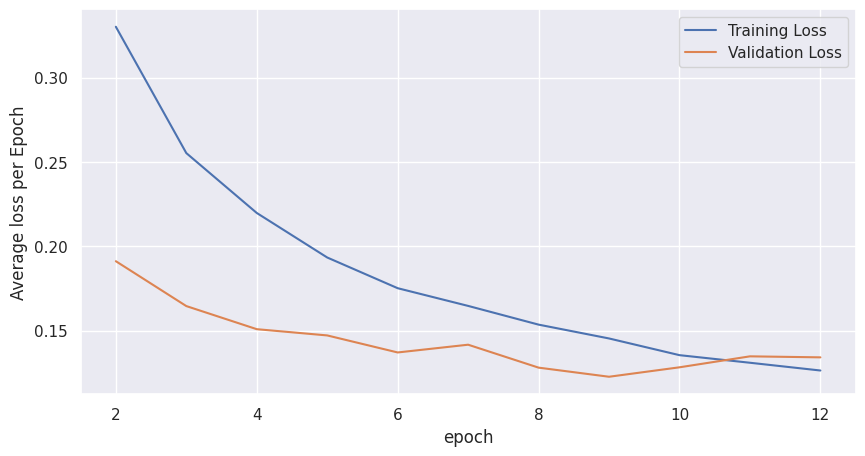

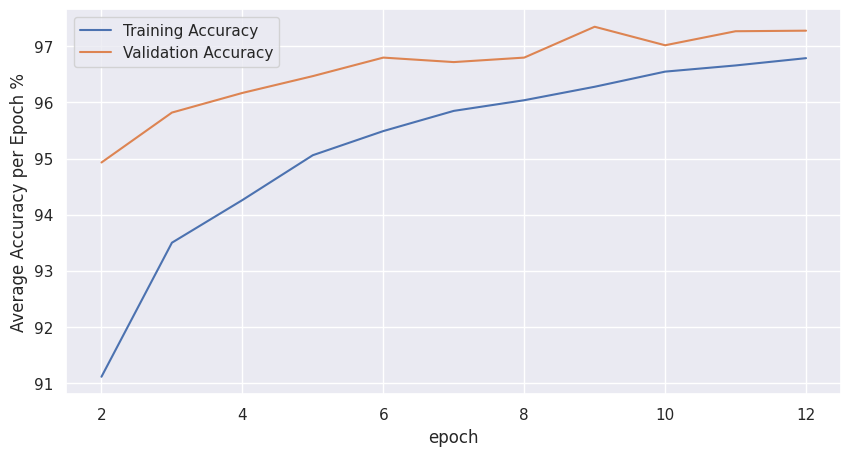

In [21]:
from matplotlib.pyplot import figure
# figure(figsize=(4, 6), dpi=200)
figure(figsize=(10, 5))

# plt.plot(train_batch_losses, label = "Adam Optimizer")
# plt.plot(train_epoch_losses2, marker="_", label = "Adam Optimizer")

# the difference in the first train loss and validation loss is very high, to understand the plot, it is better to exclude it
# plt.plot(range(1,n_epochs+1), train_epoch_losses, label = "Training Loss")
# plt.plot(range(1,n_epochs+1), validation_epoch_losses, label = "Validation Loss")
plt.plot(range(2,n_epochs+1), train_epoch_losses[1:], label = "Training Loss")
plt.plot(range(2,n_epochs+1), validation_epoch_losses[1:], label = "Validation Loss")

plt.xlabel('epoch')
plt.ylabel('Average loss per Epoch')
plt.legend()
plt.show()

### plot accuracy
figure(figsize=(10, 5))

# the difference in the first train accuracy and validation accuracy is very high, to understand the plot, it is better to exclude it
# plt.plot(range(1,n_epochs+1), train_epoch_accuracy, label = "Training Accuracy")
# plt.plot(range(1,n_epochs+1), validation_epoch_accuracy, label = "Validation Accuracy")
plt.plot(range(2,n_epochs+1), train_epoch_accuracy[1:], label = "Training Accuracy")
plt.plot(range(2,n_epochs+1), validation_epoch_accuracy[1:], label = "Validation Accuracy")


plt.xlabel('epoch')
plt.ylabel('Average Accuracy per Epoch %')
plt.legend()
plt.show()
# print(type(train_epoch_accuracy))

In [22]:
# # sum=0
# # for sample_i, (input, target) in enumerate(trainloader):
# #     print(target)
# #     # break


# # it contains the result for the last batch (batch of 5 samples)
# # the output of final layer was 16

# print(y_hat.shape) 
# print(target)
# print((y_hat[0]))


In [23]:
# # torch.max(y_hat.data, 1)
# y_hat

Define Test

In [24]:
def test(model, testloader, verbose=1):
    model.eval()

    batch_loss = []
    batch_accuracy = []
    with torch.no_grad():
        for batch_id, (input, target) in enumerate(testloader):
            # calculate the prediction
            y_hat = model(input)
            
            # calculate the loss
            loss = criterion(y_hat, target)
            current_loss = loss.item()
            batch_loss.append(current_loss)
            # loss_sum += current_loss
            
            # caclculate test accuracy
            _, predicted = torch.max(y_hat.data, 1)
            batch_samples_count = target.size(0)
            correct_pred_batch = (predicted == target).sum().item()
            batch_accuracy.append(round((correct_pred_batch / batch_samples_count) * 100, 2))
            if(verbose):
                print(f'Batch: {batch_id+1}, Test Loss: {batch_loss[-1]}, Test Accuracy: {batch_accuracy[-1]}%')
        avg_loss = round(sum(batch_loss) / len(batch_loss), 4)
        avg_accuracy = round(sum(batch_accuracy) / len(batch_accuracy), 4)
        return avg_loss, avg_accuracy

### Test the model

In [25]:


test_result = test(model, testloader, verbose=1)
print(f'Average Loss: {test_result[0]}, Average Accuracy; {test_result[1]}%')

# Average Loss: 1.5002, Average Accuracy; 96.08%
# after 100 epochs: Average Loss: 1.4938, Average Accuracy; 96.73%
# after 10 epochs of training: Average Loss: 0.0994, Average Accuracy; 97.5%
# after 7 epochs of training: Average Loss: 0.1072, Average Accuracy; 96.85%

# After 10 epochs Net2: Average Loss: 0.1251, Average Accuracy; 97.14%



Batch: 1, Test Loss: 0.13441278040409088, Test Accuracy: 97.3%
Batch: 2, Test Loss: 0.08914497494697571, Test Accuracy: 98.2%
Batch: 3, Test Loss: 0.17237597703933716, Test Accuracy: 96.9%
Batch: 4, Test Loss: 0.13262464106082916, Test Accuracy: 97.3%
Batch: 5, Test Loss: 0.08635421097278595, Test Accuracy: 97.7%
Batch: 6, Test Loss: 0.0812535434961319, Test Accuracy: 97.9%
Batch: 7, Test Loss: 0.08507335931062698, Test Accuracy: 97.9%
Batch: 8, Test Loss: 0.13347533345222473, Test Accuracy: 97.2%
Batch: 9, Test Loss: 0.07771414518356323, Test Accuracy: 98.2%
Batch: 10, Test Loss: 0.11096074432134628, Test Accuracy: 97.6%
Average Loss: 0.1103, Average Accuracy; 97.62%


In [33]:
# torch.save(model, 'mnist_model_pytorch.pt')

#### Examples print

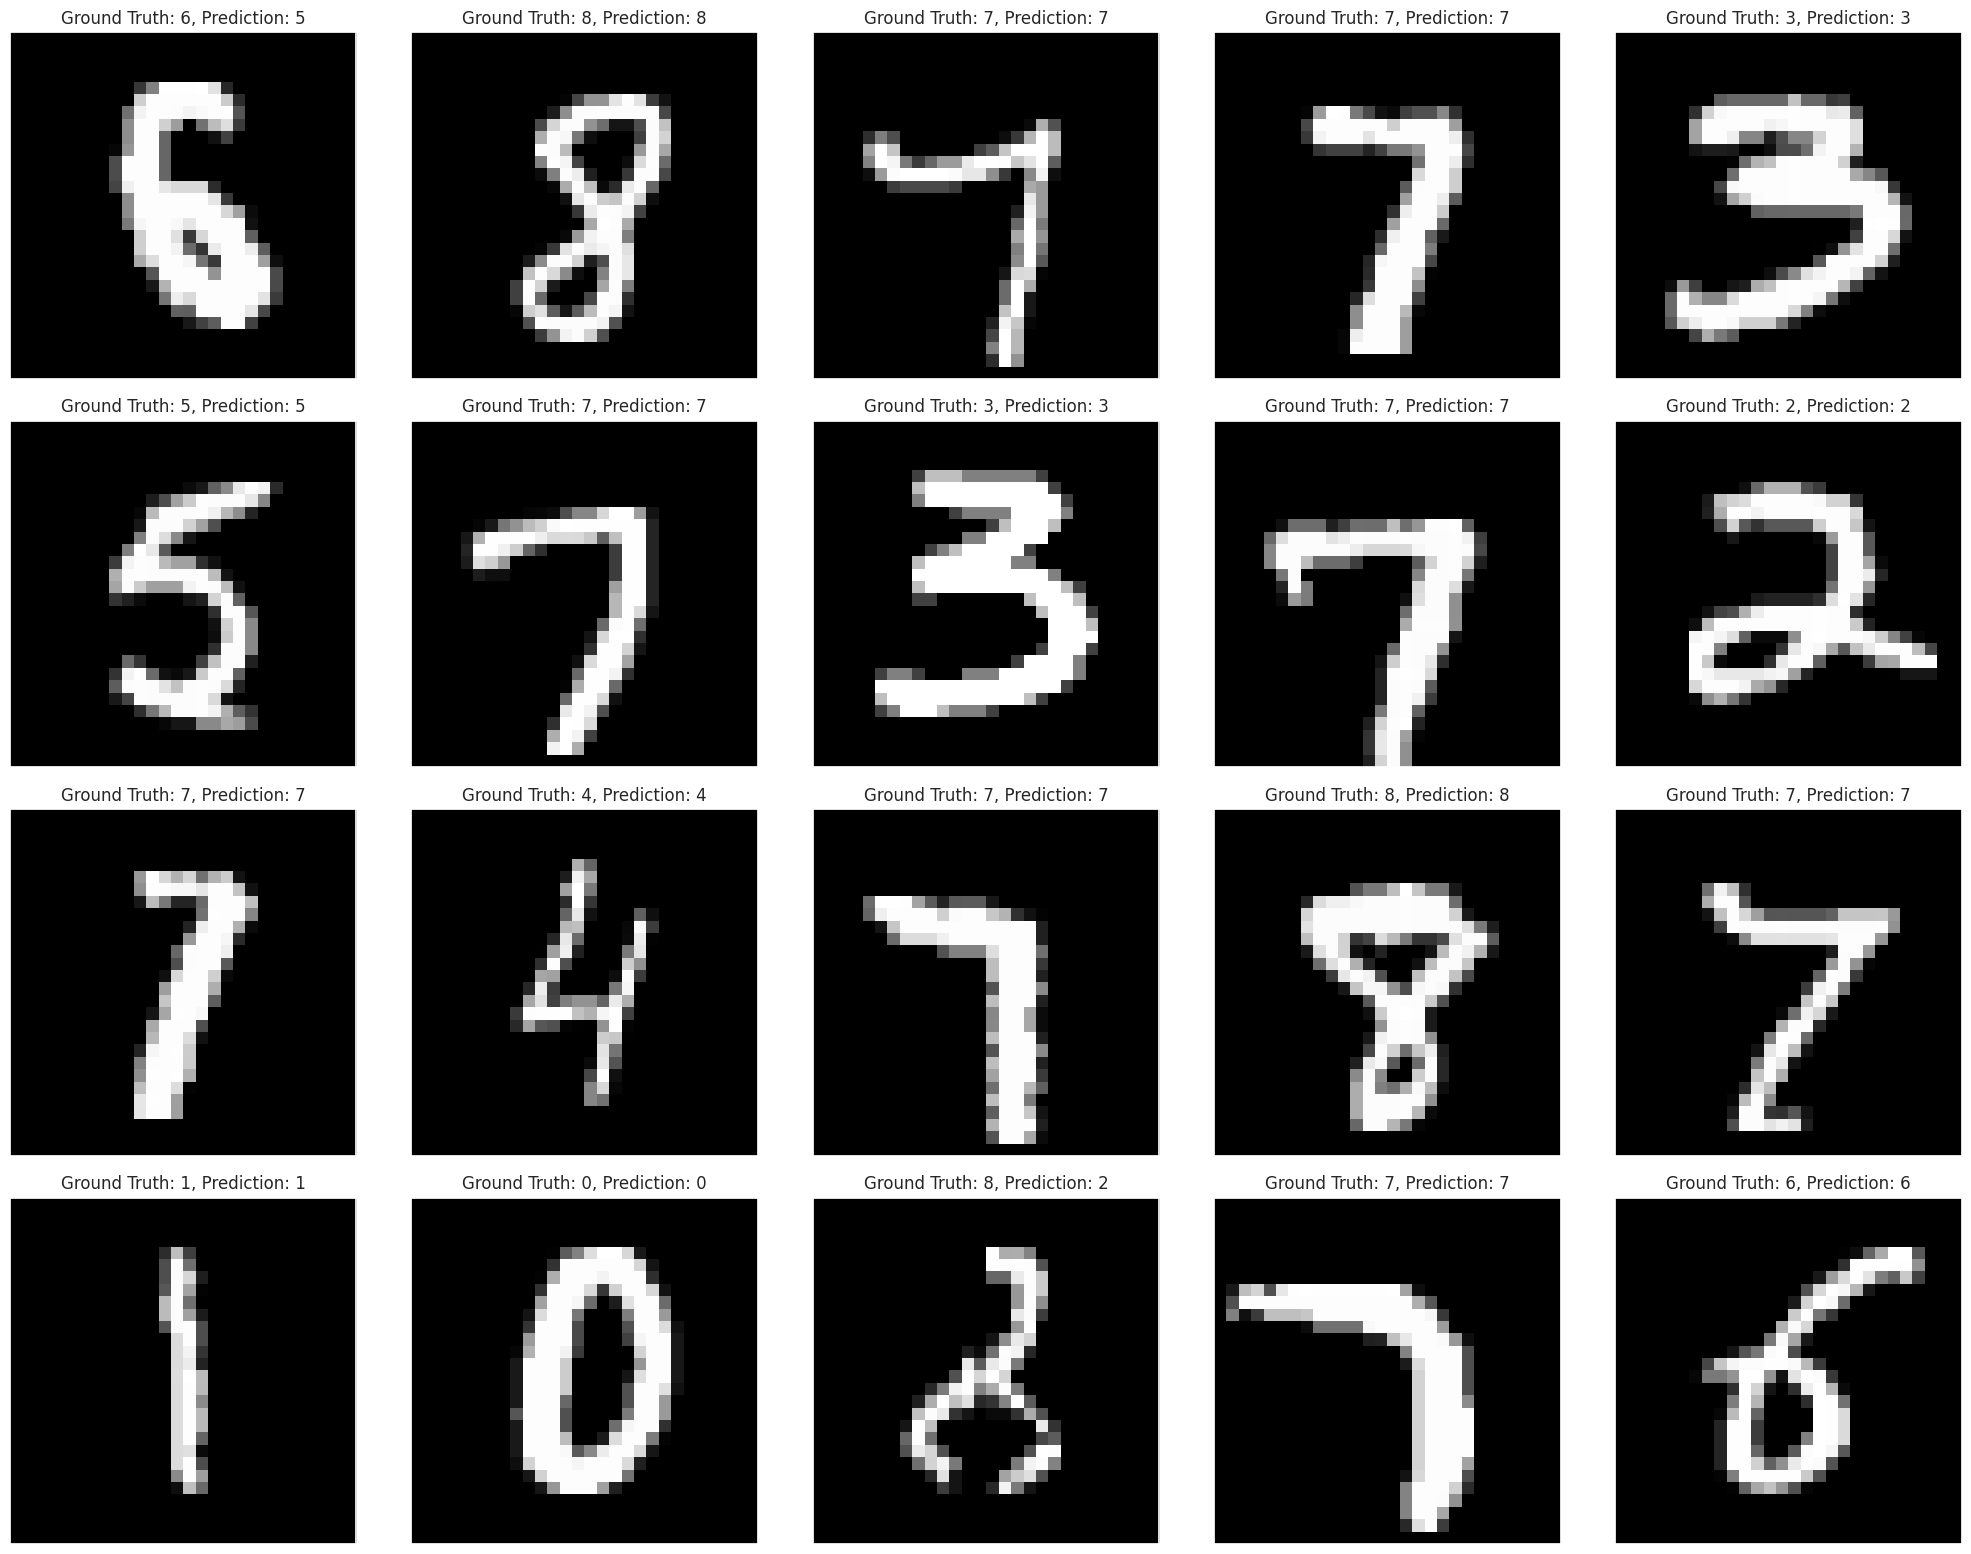

In [40]:
with torch.no_grad():
    output = model(images[400:])


fig = plt.figure(figsize=(20,16))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.tight_layout()
  plt.imshow(images[400:][i][0], cmap='gray', interpolation='none')
  # plt.title()
  plt.title(f"Ground Truth: {labels[400:][i]}, Prediction: {output.data.max(1, keepdim=True)[1][i].item()}")
  plt.xticks([])
  plt.yticks([])
fig;